In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
import pickle 

In [6]:
from src.dataloader import *
from ilan_src.models import *
from ilan_src.utils import *

In [8]:
DATADRIVE = '/datadrive_ssd/'

test_ds = pickle.load(open("/datadrive_ssd/saved_datasets/testdataset_single_forecast_only_log_trans_first_days_2.pkl", "rb"))

In [9]:
LEARNING_RATE = 1e-4
IMG_SIZE = 128
CHANNELS_IMG = 1
NOISE_SHAPE = (1, 16, 16)
NUM_EPOCHS = 30
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 10

model = LeinGANGP(LeinGen, LeinDisc, 
                  NOISE_SHAPE, CHANNELS_IMG, 
                  IMG_SIZE, GEN_EMBEDDING, 
                  lr = LEARNING_RATE,
                  lambda_gp=LAMBDA_GP)
gen = model.gen

In [10]:
gen.load_state_dict(torch.load("./models/model-leingan-gen-single-forecast-version-88.m"))

<All keys matched successfully>

In [11]:
gen = gen.to(device)

In [12]:
gen

LeinGen(
  (embed): Conv2d(1, 255, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (process): Sequential(
    (0): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (upscale): Sequential(
    (0): LeinResBlock(
      (shortcut): Sequential()
      (convblock1): ConvBlock(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (convblock2): ConvBlock(
        (conv): Conv2d(256, 256, kernel_

In [13]:
sampler_test = torch.utils.data.WeightedRandomSampler(test_ds.compute_weights(), len(test_ds))
dl_test = torch.utils.data.DataLoader(
    test_ds, batch_size=32, sampler=sampler_test
)

In [20]:
def plot_samples_per_input(cond, target, gen, k=1, samples = 3):
    fig, axs = plt.subplots(k, samples+2, figsize=(15, k*5))
    gen_images = np.zeros((k,samples+2,128,128))
    with torch.no_grad():    
        for i in range(4):
            noise = torch.randn(cond.shape[0], 1, cond.shape[2], cond.shape[3]).to(device)
            pred = gen(cond, noise).detach().cpu().numpy()
            for j in range(k):
                gen_images[j,i,:,:] = pred[j, 0] 

    for j in range(k):
        lr = cond[j, 0].detach().cpu().numpy()
        hr = target[j, 0].detach().cpu().numpy()
        mn = np.min([np.min(hr), np.min(pred), np.min(gen_images[j,i,:,:])])
        mx = np.max([np.max(hr), np.max(pred), np.max(gen_images[j,i,:,:])])
        im = axs[j,0].imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        im = axs[j,1].imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
#         plt.colorbar(im, ax=axs[j,0], shrink=0.7)
        for i in range(samples):
            im = axs[j,i+2].imshow(gen_images[j,i,:,:], vmin=mn, vmax=mx, cmap='gist_ncar_r')
#             plt.colorbar(im, ax=axs[j,i], shrink=0.7)
    plt.show()  

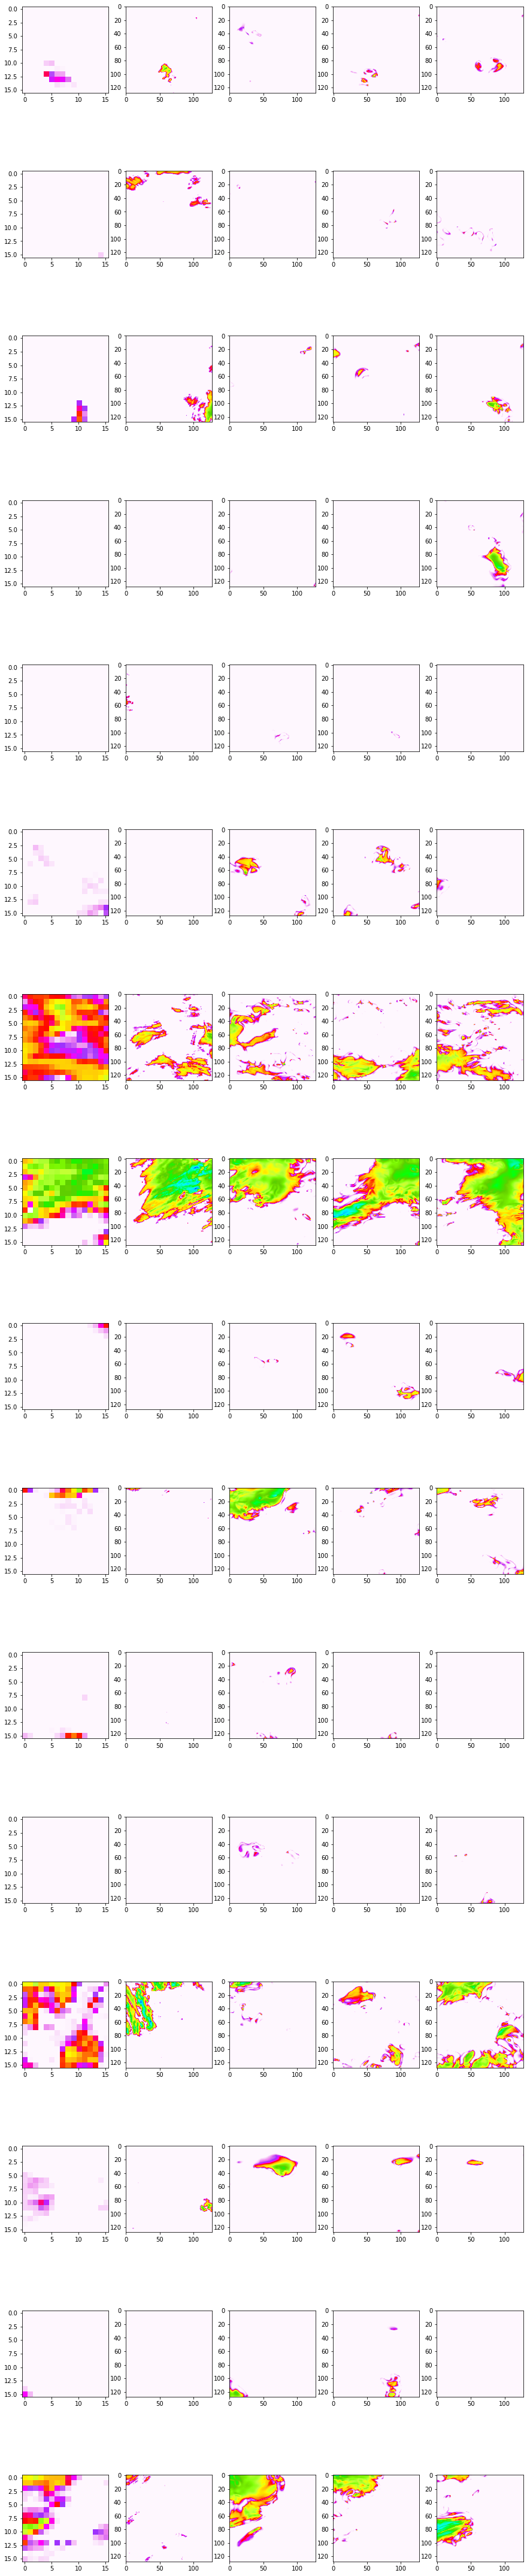

In [29]:
x_sample, y_sample = next(iter(dl_test))
x_sample, y_sample = x_sample.to(device), y_sample.to(device)
plot_samples_per_input(x_sample, y_sample, model.gen, k=16)

## Evaluation

### Get predictions

In [96]:
# Note that we are using xarray datasets for handling our data!
# This makes things SO MUCH easier :)
def create_valid_predictions(model, ds_valid):
    # Get predictions for full field
    preds = []
    for t in tqdm.tqdm(range(len(ds_valid.tigge.valid_time))):
        X, y = ds_valid.return_full_array(t)
        noise = torch.randn(1, 1, X.shape[1], X.shape[2]).to(device)
#         print(noise.shape)
        pred = model(torch.FloatTensor(X[None]).to(device), noise).to('cpu').detach().numpy()[0, 0]
        preds.append(pred)
    preds = np.array(preds)
    
    # Unscale
    preds = preds * (ds_valid.maxs.tp.values - ds_valid.mins.tp.values) + ds_valid.mins.tp.values
    
    # Convert to xarray
    preds = xr.DataArray(
        preds,
        dims=['valid_time', 'lat', 'lon'],
        coords={
            'valid_time': ds_valid.tigge.valid_time,
            'lat': ds_valid.mrms.lat.isel(
                lat=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[1])
            ),
            'lon': ds_valid.mrms.lon.isel(
                lon=slice(ds_valid.pad_mrms, ds_valid.pad_mrms+preds.shape[2])
            )
        },
        name='tp'
    )
    return preds

In [97]:
def create_valid_ensemble(model, ds_valid, nens):
    """Wrapper to create ensemble"""
    preds = [create_valid_predictions(model, ds_valid) for _ in range(nens)]
    return xr.concat(preds, 'member')

In [98]:
det_pred = create_valid_predictions(gen, ds_test)

  0%|          | 0/44 [00:00<?, ?it/s]

In [36]:
det_pred

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[2.24190354e+00, 2.06186190e-01, 9.88658965e-02, ...,
         8.56506646e-01, 5.50225019e-01, 2.55329967e+00],
        [1.05592936e-01, 2.93320473e-02, 1.33830104e-02, ...,
         2.16146135e+00, 2.06699514e+00, 2.43479753e+00],
        [5.57743274e-02, 9.82968323e-03, 5.84161794e-03, ...,
         6.13232088e+00, 6.52809334e+00, 6.99259758e+00],
        ...,
        [1.33473240e-02, 2.87081767e-03, 2.72736419e-03, ...,
         3.56815040e-01, 5.49808383e-01, 3.63706565e+00],
        [2.07515024e-02, 4.28734347e-03, 3.68764740e-03, ...,
         2.99685210e-01, 4.82035309e-01, 3.92343163e+00],
        [5.44202387e-01, 3.66581641e-02, 4.30323966e-02, ...,
         7.90864229e-01, 1.12004828e+00, 1.22368460e+01]],

       [[2.67832828e+00, 1.83752209e-01, 7.85825998e-02, ...,
         6.93575211e+01, 7.15036621e+01, 8.13255997e+01],
        [1.60131603e-01, 4.45307083e-02, 2.13393271e-02, ...,
         4.44998245e+01, 5.15078621e+01, 4.40249367e+01],
        [9.64142904e-02, 3.01840436e-02, 2.04823632e-02, ...,
         1.83374214e+01, 2.17535458e+01, 3.39746017e+01],
...
        [2.15383451e-02, 9.37567931e-03, 1.12791490e-02, ...,
         6.59463331e-02, 4.04069014e-02, 9.34649706e-02],
        [3.54839191e-02, 2.76921690e-02, 3.48808952e-02, ...,
         5.28860949e-02, 3.84881534e-02, 1.14016369e-01],
        [8.54315639e-01, 2.44390622e-01, 4.14288253e-01, ...,
         1.29322231e-01, 1.28241703e-01, 1.37047029e+00]],

       [[2.01139069e+00, 2.10861310e-01, 1.08621418e-01, ...,
         4.43406165e-01, 6.26911223e-01, 1.05453148e+01],
        [1.05718181e-01, 4.67765294e-02, 2.42701564e-02, ...,
         6.36466622e-01, 1.55185020e+00, 7.75983191e+00],
        [6.22633807e-02, 1.76450387e-02, 1.18407784e-02, ...,
         1.86785102e+00, 4.13411856e+00, 1.39049482e+01],
        ...,
        [9.29318294e-02, 2.37771887e-02, 1.73866507e-02, ...,
         1.33182183e-01, 1.44956335e-01, 7.67549276e-01],
        [1.47573873e-01, 2.80766394e-02, 1.71663500e-02, ...,
         1.16911329e-01, 1.40249088e-01, 9.25019503e-01],
        [2.29494095e+00, 1.48566276e-01, 1.17435575e-01, ...,
         3.24160904e-01, 4.17166293e-01, 5.29895353e+00]]], dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [ ]:
ens_pred = create_valid_ensemble(gen, ds_test, nens=100)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [100]:
ens_pred

<xarray.DataArray 'tp' (member: 10, valid_time: 44, lat: 744, lon: 1376)>
array([[[[5.27514410e+00, 4.98933268e+00, 4.93268871e+00, ...,
          1.09730169e-01, 1.32601127e-01, 1.93570900e+00],
         [4.43204546e+00, 4.54770708e+00, 4.73987293e+00, ...,
          5.42020833e-04, 2.58845044e-04, 9.03061256e-02],
         [4.12416077e+00, 4.23753452e+00, 4.49437094e+00, ...,
          1.49314827e-03, 7.83105788e-04, 2.38676488e-01],
         ...,
         [2.60756788e-05, 5.01607531e-07, 3.49031054e-10, ...,
          9.13535210e-27, 4.93462867e-25, 4.31063944e-14],
         [3.17589351e-04, 1.41757264e-05, 2.32441657e-08, ...,
          8.68227609e-25, 8.99167641e-24, 1.05012722e-12],
         [1.03185391e-02, 1.35085627e-03, 1.55401503e-05, ...,
          1.18073455e-16, 1.73651368e-15, 4.01861477e-08]],

        [[5.55064869e+00, 5.51394510e+00, 5.42572069e+00, ...,
          1.50410966e-18, 1.23306059e-14, 4.98409358e-09],
         [4.87795591e+00, 4.97874546e+00, 5.07112789e+00, ...,
          2.96962270e-24, 2.21215932e-20, 1.16486329e-13],
         [4.76124001e+00, 4.81644869e+00, 4.98334503e+00, ...,
          1.42763024e-26, 1.98019814e-22, 9.39746937e-14],
...
          4.97641460e-29, 1.81492696e-24, 8.49016929e-13],
         [1.38308876e-19, 2.13185823e-26, 8.09519226e-37, ...,
          2.55065453e-25, 1.41173901e-21, 6.56121407e-11],
         [2.44147909e-12, 5.74260280e-16, 1.13334652e-23, ...,
          5.57367638e-16, 1.64282718e-13, 6.41059387e-07]],

        [[2.34386448e-06, 1.02417796e-09, 8.88214988e-11, ...,
          2.69487500e-01, 4.74029750e-01, 1.64478409e+00],
         [2.54149257e-09, 1.66270589e-13, 5.57942567e-14, ...,
          1.05277240e-01, 1.89124346e-01, 1.08626306e+00],
         [4.40755453e-11, 1.80482850e-14, 1.29770911e-15, ...,
          1.67347282e-01, 2.93370306e-01, 1.65762019e+00],
         ...,
         [5.07836551e-20, 8.19031368e-27, 1.88181514e-36, ...,
          1.76827136e-24, 4.88734987e-23, 1.29132122e-12],
         [3.25033991e-16, 5.14059429e-22, 2.32183221e-31, ...,
          5.45808001e-23, 2.58044934e-22, 1.16479109e-11],
         [4.99443487e-10, 5.27736058e-13, 1.27113181e-19, ...,
          1.34779984e-14, 4.92733905e-14, 3.02686800e-07]]]],
      dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
Dimensions without coordinates: member

### Compute scores

In [101]:
from src.evaluation import *

Need to mask out regions where there is no radar

In [102]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [103]:
eval_mask

<xarray.DataArray (lat: 750, lon: 1376)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] ...
  * lat      (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon      (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 289.9 290.0 290.0

In [104]:
import xskillscore as xs

In [105]:
mrms = ds_test.mrms.sel(lat=det_pred.lat, lon=det_pred.lon).rename(
    {'time': 'valid_time'}) * ds_test.maxs.tp.values
mrms = mrms.where(eval_mask)

In [106]:
mrms

<xarray.DataArray 'tp' (valid_time: 44, lat: 744, lon: 1376)>
array([[[0.        , 0.81093025, 0.48550797, ..., 4.18965483,
         3.58351898, 2.8834033 ],
        [0.        , 0.        , 1.79175949, ..., 4.45434761,
         3.89436817, 3.04452252],
        [0.        , 1.25276303, 1.89085031, ..., 4.35510492,
         4.04742765, 3.30505347],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.        , 0.        , 0.        , ..., 4.3307333 ,
         4.47591543, 4.59005642],
        [0.        , 0.        , 0.        , ..., 3.84213686,
         4.09016895, 4.27144432],
        [0.        , 0.        , 0.        , ..., 3.78702664,
         3.97968173, 4.3307333 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.4 20.36 20.32 20.28
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] 2020-05-16

In [107]:
# Deterministic forecast RMSE
xs.rmse(det_pred, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.70565726)

In [108]:
# Emsemble mean forecast RMSE
xs.rmse(ens_pred.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.41044577)

In [109]:
# Ensemble CRPS
xs.crps_ensemble(mrms, ens_pred).values

array(0.46666219)

### Interpolation baseline

In [110]:
tigge = ds_test.tigge.isel(variable=0) * ds_test.maxs.tp.values
tigge

<xarray.DataArray (valid_time: 44, lat: 93, lon: 172)>
array([[[4.04470158e+00, 5.11030436e+00, 5.82750654e+00, ...,
         4.53241920e+00, 4.45992851e+00, 4.44559288e+00],
        [4.11456728e+00, 3.36185122e+00, 4.13695717e+00, ...,
         4.40880680e+00, 4.46000957e+00, 4.57957888e+00],
        [6.06317234e+00, 5.59141588e+00, 4.37500525e+00, ...,
         4.30664730e+00, 4.38628531e+00, 4.50235939e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.71274948e-02, 1.22458935e-01, 5.91239929e-02],
        [4.47537899e-01, 0.00000000e+00, 0.00000000e+00, ...,
         2.28205037e+00, 1.59306645e+00, 3.28119421e+00],
        [4.39067364e-01, 1.17049217e-02, 1.83172226e-02, ...,
         4.01330948e+00, 3.71006417e+00, 3.43902588e+00]],

       [[5.09296036e+00, 4.48277044e+00, 5.07895470e+00, ...,
         3.10445833e+00, 2.71712446e+00, 2.36485171e+00],
        [2.25218749e+00, 9.15989637e-01, 2.59699821e+00, ...,
         3.47094202e+00, 3.03526378e+00, 2.38259506e+00],
        [4.72918177e+00, 3.66090703e+00, 1.97954845e+00, ...,
         3.77639747e+00, 3.34980154e+00, 2.64851689e+00],
...
        [1.28159523e-02, 1.74113750e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.39893055e-01, 0.00000000e+00, 8.70885849e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.92164135e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.52678728e+00, 3.28831959e+00, 2.90560770e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.78704786e+00, 1.80664206e+00, 1.60702515e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.41824007e+00, 8.42699051e-01, 9.66427088e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.88731050e+00, 3.03652287e+00, 5.70996284e-01],
        [0.00000000e+00, 0.00000000e+00, 3.83092403e-01, ...,
         3.88607073e+00, 2.89797568e+00, 6.78832054e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.01289272e+00, 3.71410441e+00, 2.82149386e+00]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    init_time   (valid_time) datetime64[ns] 2020-01-01 ... 2020-12-02
  * lon         (lon) float64 235.2 235.5 235.8 236.2 ... 289.3 289.6 289.9
  * lat         (lat) float64 49.68 49.36 49.04 48.72 ... 21.2 20.88 20.56 20.24
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
    variable    <U2 'tp'

In [111]:
interp = tigge.interp_like(mrms, method='linear')

In [112]:
# Deterministic baseline RMSE
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.64717148)

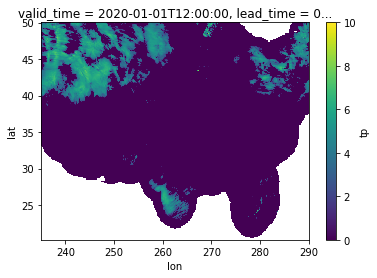

In [117]:
mrms.isel(valid_time=0).plot(vmin=0, vmax=10)

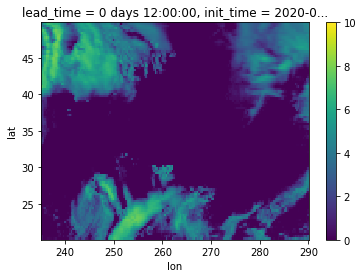

In [118]:
tigge.isel(valid_time=0).plot(vmin=0, vmax=10)

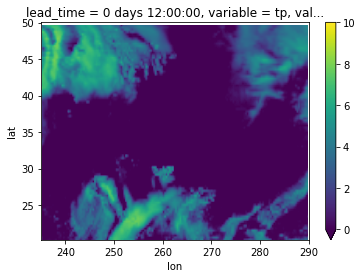

In [119]:
interp.isel(valid_time=0).plot(vmin=0, vmax=10)

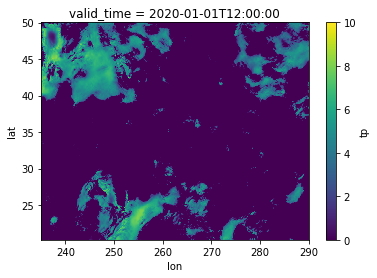

In [120]:
det_pred.isel(valid_time=0).plot(vmin=0, vmax=10)

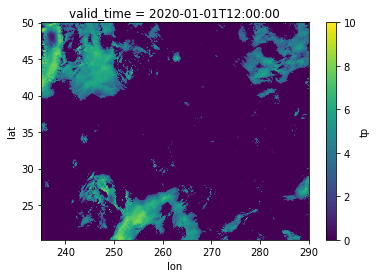

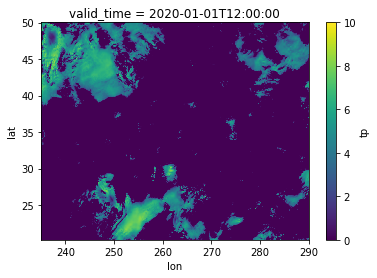

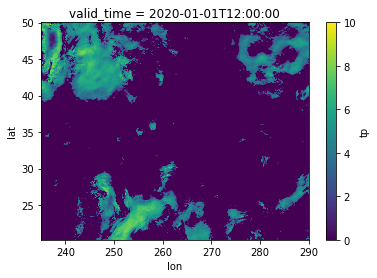

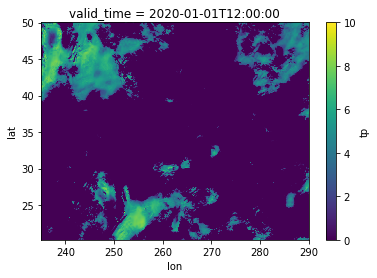

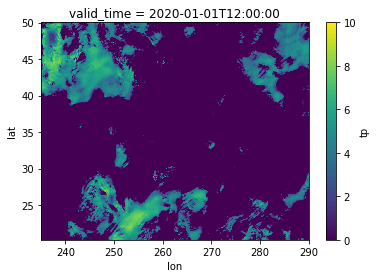

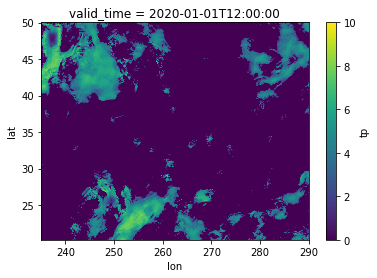

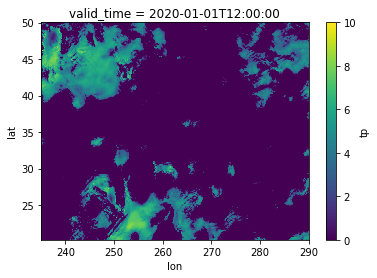

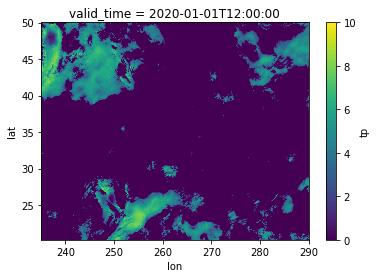

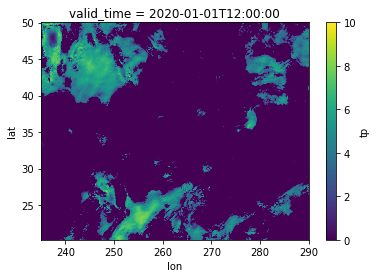

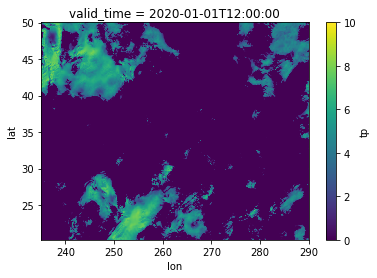

In [125]:
for i in range(10):
    plt.figure()
    ens_pred.isel(valid_time = 0, member=i).plot(vmin=0, vmax=10)